# Combined inner and outer rings

## Kieran's spiral pattern as Python 

In [1]:
import numpy as np
from math import sin, log10, cos, atan2, hypot

# Region values
black = -1
white = 1
grey = 0

# Physical dimensions
r_max = 300.
r_min = 50.
r_split = 246. # interface between main sprial and outer rim

npix=512 # pixels spanning -r_max to + r_max

# Spiral parameters
alpha1 = 20.186
m1 = 5
eta1 = -1.308
m2 = -5
alpha2 = 16.149
eta2 = -0.733
m3 = 10
alpha3 = 4.0372
eta3 = -0.575

a = np.zeros(shape=(npix,npix))
for i in range(npix):
    for j in range(npix):
        x = i - npix/2.
        y = j - npix/2.
        phi = atan2(y, x)
        r = r_max*hypot(x,y)*2./npix        
        if (r<=r_max and r>r_min):
            c1 = cos(alpha1*log10(r)+m1*phi+eta1)
            c2 = cos(alpha2*log10(r)+m2*phi+eta2)
            c3 = sin(alpha3*log10(r)+m3*phi+eta3)
            if (r>r_split): # Outer rim
                a[i][j]=white if (c3<0 or c1*c2*c3>0) else black
            else: # Main spiral
                a[i][j]=white if (c1*c2*c3>0) else black
        else: # Colour to distinguish from above values
            a[i][j] = grey


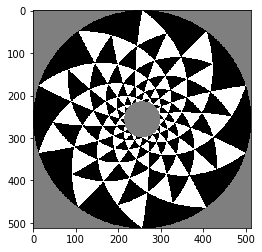

In [2]:
import matplotlib.pyplot as plt
plt.imshow(a,cmap='binary')
plt.show()

# Use in PROPER

In [3]:
import numpy as np
from math import sin, log10, cos, atan2, hypot

def spiral(r, phi):
    # Spiral parameters
    alpha1 = 20.186
    m1 = 5
    eta1 = -1.308
    m2 = -5
    alpha2 = 16.149
    eta2 = -0.733
    m3 = 10
    alpha3 = 4.0372
    eta3 = -0.575    

    s = 0.15/300. # m/internal sampling dist
    # Physical dimensions
    r_max = 300.
    r_min = 50.
    r_split = 246. # interface between main sprial and outer rim    
    
    white = 0
    wl_target = 6e-6 # metres
    black = wl_target/4.
    v = white
    r = r/s
    if (r<=r_max and r>r_min):
        c1 = cos(alpha1*log10(r)+m1*phi+eta1)
        c2 = cos(alpha2*log10(r)+m2*phi+eta2)
        c3 = sin(alpha3*log10(r)+m3*phi+eta3)
        if (r>r_split): # Outer rim
            v=white if (c3<0 or c1*c2*c3>0) else black
        else: # Main spiral
            v=white if (c1*c2*c3>0) else black
    return v

In [1]:
# Add local scripts to module search path
import sys
import os
sys.path.append(os.path.realpath('../toliman-proper'))

In [5]:
prescription_vals = {
                    'diam': 0.001 * 2. * 150, 
                    'm1_fl': 0.5717255, 
                    'm1_m2_sep': 0.54933763033373, 
                    'm2_fl': -0.02337895948640,  
                    'bfl': 0.52761,  
                    'm2_rad': 0.00590401477581,
                    'm2_strut_width': 0.01,
                    'm2_supports': 5,
                    'beam_ratio': 0.4
                    }
prescription_vals['phase_func'] = spiral


# Applied to wavefront phase grid

Use sampling and grid size as used in PROPER simulations

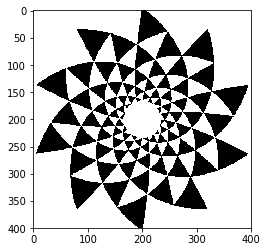

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import math

ngrid = 2048
sampling = 0.0007324218749999999
phase_map = np.zeros([ngrid, ngrid], dtype = np.float64)
c = ngrid/2.
phase_func = spiral
for i in range(ngrid):
    for j in range(ngrid):
        x = i - c
        y = j - c
        phi = math.atan2(y, x)
        r = sampling*math.hypot(x,y)
        phase_map[i][j] = phase_func(r, phi)
plt.imshow(phase_map[824:1224,824:1224] ,cmap='binary')
plt.show()


## Applied to single lens system

In [7]:
import proper
import numpy as np

wavelength = 0.6 # microns
gridsize = 2048
prescription_vals['phase_func'] = spiral
(wavefront, sampling) = proper.prop_run('prescription_quad', wavelength, gridsize, PASSVALUE=prescription_vals)


/home/ubuntu/miniconda/envs/astroconda/lib/python3.5/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


Lambda = 6.0000E-07   Throughput = 1.00
Applying lens at primary
Propagating to focus
Total elapsed time (seconds) =  16.4165


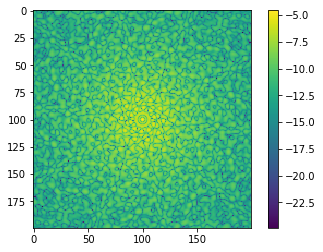

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(np.log10(np.abs(wavefront[1024-100:1024+100, 1024-100:1024+100])**2)) #,cmap='binary')
plt.colorbar()
plt.show()

# Apply to Toliman RC

In [9]:
import proper
import numpy as np

wavelength = 0.6 # microns
gridsize = 2048
prescription_vals['phase_func'] = spiral
(wavefront, sampling) = proper.prop_run('prescription_rc_quad', wavelength, gridsize, PASSVALUE=prescription_vals, QUIET=False, TABLE=True)


Lambda = 6.0000E-07   Throughput = 1.00
Propagating to primary
Applying lens at primary
Propagating to secondary
Applying lens at secondary
Propagating to focus
Total elapsed time (seconds) =  27.2304


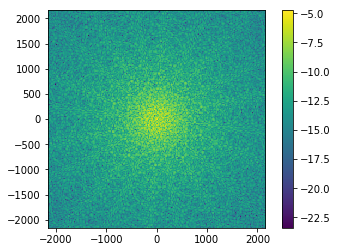

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

s = sampling/1e-6
plt.imshow(np.log10(np.abs(wavefront[1024-200:1024+200, 1024-200:1024+200])**2),cmap='viridis', extent=[x*s for x in [-200,200,-200,200]])
plt.colorbar()
plt.show()

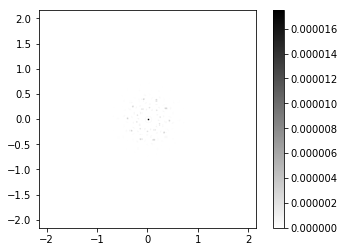

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

s = sampling/1e-3
plt.imshow(np.abs(wavefront[924:1124, 924:1124])**2,cmap='binary', extent=[x*s for x in [-200,200,-200,200]])
plt.colorbar()
plt.show()

In [12]:
print('{} mm/pixel'.format(sampling*1000))

0.010789123352263095 mm/pixel


# Modified outer ring

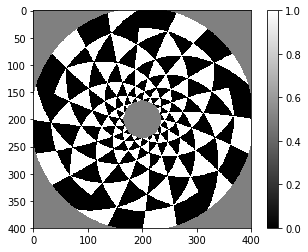

In [2]:
%matplotlib inline
import spirals
import matplotlib.pyplot as plt
import math
import numpy as np

ngrid = 2048
sampling = 0.0007324218749999999
phase_map = np.zeros([ngrid, ngrid], dtype = np.float64)
c = ngrid/2.
phase_func = spirals.binarized_ringed_flipped
for i in range(ngrid):
    for j in range(ngrid):
        x = i - c
        y = j - c
        phi = math.atan2(y, x)
        r = sampling*math.hypot(x,y)
        phase_map[i][j] = phase_func(r, phi, 0, white=1.0, empty=0.5)
plt.imshow(phase_map[824:1224,824:1224] ,cmap='gray')
plt.colorbar()
plt.show()

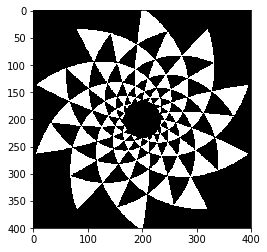

In [4]:
%matplotlib inline
import spirals
import matplotlib.pyplot as plt
import math
import numpy as np

ngrid = 2048
sampling = 0.0007324218749999999
phase_map = np.zeros([ngrid, ngrid], dtype = np.float64)
c = ngrid/2.
phase_func = spirals.binarized_ringed
for i in range(ngrid):
    for j in range(ngrid):
        x = i - c
        y = j - c
        phi = math.atan2(y, x)
        r = sampling*math.hypot(x,y)
        phase_map[i][j] = phase_func(r, phi)
plt.imshow(phase_map[824:1224,824:1224] ,cmap='gray')
plt.show()